In [115]:
import csv
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

RANDOM_SEED = 42

In [116]:
# dataset = Path('gestures_dataset_new.csv')
DATASET_CSV = Path('../gestures_dataset.csv')
DATASET_ROOT = Path('../ai_data/vgt-all')

UPLOADED_DATASET_CSV = Path('../uploaded_gestures_dataset.csv')
UPLOADED_DATASET_ROOT = Path('../ai_data/vgt-uploaded')

In [117]:
%load_ext autoreload
%autoreload 2
from sl_ai.gesture_classifier import GestureClassifier
from sl_ai.dataset import GestureDataset

gesture_dataset: GestureDataset = GestureDataset()
gesture_dataset.load_from_csv(DATASET_CSV)

uploaded_dataset: GestureDataset = GestureDataset()
uploaded_dataset.load_from_csv(UPLOADED_DATASET_CSV)

gesture_dataset.append_dataset(uploaded_dataset)

gesture_dataset.summary()

classifier: GestureClassifier = GestureClassifier(gesture_dataset=gesture_dataset)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
belgië(0 -> 0)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
hallo(7 -> 1)
verenigde staten(11 -> 2)
verenigde staten(11 -> 2)
verenigde staten(11 -> 2)
verenigde staten(11 -> 2)
verenigde staten(11 -> 2)
verenigde staten(11 -> 2)
verenigde staten(11 -> 2)
verenigde staten(11 -> 2)
verenigde staten(11 -> 2)
verenigde staten(11 -> 2)
verenigde staten(11 -> 2)
verenigde staten(11 -> 2)
verenigde staten(11 -> 2

In [118]:
classifier.train(train_size=.5)
classifier.summary()

Training model:
Dataset contain 4 gestures.
Epoch 1/1000
19/19 [==============================] - 1s 8ms/step - loss: 1.5882 - accuracy: 0.1579 - val_loss: 1.1233 - val_accuracy: 0.9000
Epoch 2/1000
19/19 [==============================] - 0s 2ms/step - loss: 1.4111 - accuracy: 0.3684 - val_loss: 1.0477 - val_accuracy: 0.9000
Epoch 3/1000
19/19 [==============================] - 0s 2ms/step - loss: 1.4058 - accuracy: 0.3158 - val_loss: 1.0257 - val_accuracy: 0.9000
Epoch 4/1000
19/19 [==============================] - 0s 2ms/step - loss: 1.4723 - accuracy: 0.4737 - val_loss: 1.0156 - val_accuracy: 0.9000
Epoch 5/1000
19/19 [==============================] - 0s 2ms/step - loss: 1.2939 - accuracy: 0.5263 - val_loss: 0.9761 - val_accuracy: 0.9000
Epoch 6/1000
19/19 [==============================] - 0s 2ms/step - loss: 1.0896 - accuracy: 0.4737 - val_loss: 0.9043 - val_accuracy: 0.9000
Epoch 7/1000
19/19 [==============================] - 0s 2ms/step - loss: 1.1923 - accuracy: 0.6316 - va

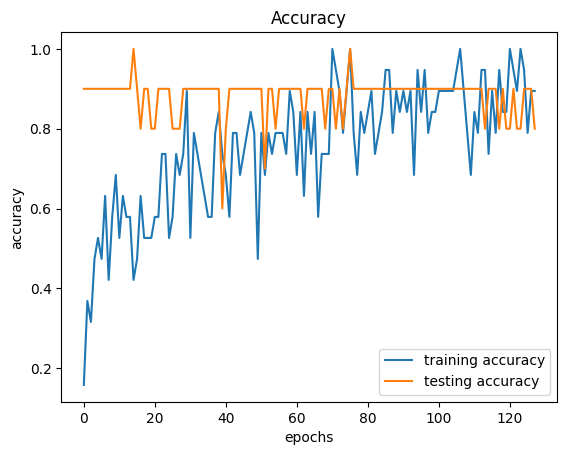

In [119]:
classifier.visualize_accuracy()

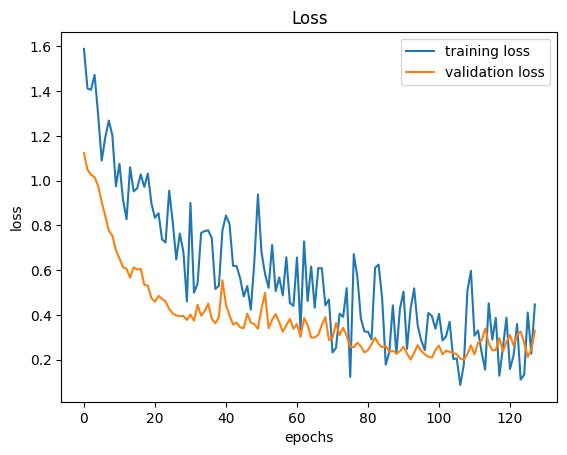

In [120]:
classifier.visualize_loss()

1/1 [==============================] - 0s 41ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         1
           2       1.00      0.67      0.80         3
           3       0.75      1.00      0.86         3

    accuracy                           0.90        10
   macro avg       0.94      0.92      0.91        10
weighted avg       0.93      0.90      0.90        10



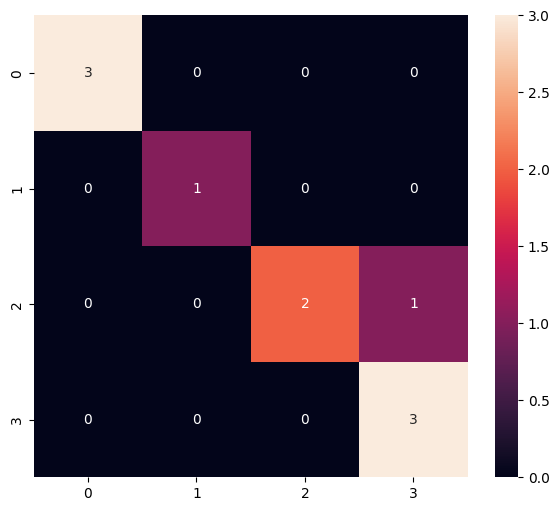

In [121]:
classifier.confusion_matrix()